In [130]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sklearn
import os
import time

In [131]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [132]:
# !pip3 install --upgrade wandb
# !pip install scikit-learn

In [133]:
# import wandb
# from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
# wandb.login()

In [134]:
lr = 0.005 #Learning rate
epochs = 25
bs = 120 #batch size
loss = "mse"
optimizer = "RMSprop"
regularizer = "No"

In [135]:
run = wandb.init(
    settings=wandb.Settings(x_disable_stats=False, x_stats_sampling_interval = 1.0),
    # set the wandb project where this run will be logged
    name = "Intento_intento_con_dropout",
    project = "Creacion_de_regresion_lineal",
    group = "Sin",

    # track hyperparameters and run metadata with wandb.config
    config = {
        "layer_1": 512,
        #"layer_2": 512,
        "activation": "relu",
        "w_initializer": "He Initialization",
        "optimizer": optimizer,
        "loss": loss,
        "metric": "accuracy",
        "epoch": epochs,
        "batch_size": bs,
        "layer_quantity": 1,
        "regularizer": regularizer,
        "Modelo": "Sin"
    }
)
time.sleep(3.0)

# Preparando la red neuronal (Recolección de datos y preprocesamiento)

## Definimos las funciones que queremos usar

In [145]:
domain = np.linspace(-1,1,50000)
np.random.choice(domain, size=10000, replace=True)

def function_1(domain):
    return 3*np.sin(np.pi * domain)

def function_2(domain):
    return 1 + 2*domain + 4*(domain**3)

codomain_sin = function_1(domain)
codomain_pol = function_2(domain)

#Transformamos los arreglos de numpy en vectores para que keras los reconozca
domain = domain.reshape(-1,1)
codomain_sin = codomain_sin.reshape(-1,1)
codomain_pol = codomain_pol.reshape(-1,1)

## Creamos los datos que va a recibir la red neuronal

In [137]:
#Se dividen los datos en train y test de tipo 80:20 (train:test) y se deja el random state fijo para replicabilidad

X_train_sin, X_test_sin, y_train_sin, y_test_sin = train_test_split(domain, codomain_sin, test_size=0.2, random_state=42)

X_train_pol, X_test_pol, y_train_pol, y_test_pol = train_test_split(domain, codomain_pol, test_size=0.2, random_state=57) 

## Escalamos los datos (estandarización)

In [138]:
scale = StandardScaler()

X_train_sin, y_train_sin = scale.fit_transform(X_train_sin), scale.fit_transform(y_train_sin)
X_test_sin, y_test_sin = scale.transform(X_test_sin), scale.transform(y_test_sin)

X_train_pol, y_train_pol = scale.fit_transform(X_train_pol), scale.fit_transform(y_train_pol)
X_train_pol, y_train_pol = scale.transform(X_train_pol), scale.transform(y_train_pol)

# Creación de la red neuronal

In [139]:
entrada = 1
stddev1 = np.sqrt(2/entrada)
stddev2 = np.sqrt(2/512)

model_sin = keras.Sequential(
    [
        layers.Dense(512, activation = "relu", name = "layer1", 
                     kernel_initializer=initializers.RandomNormal(stddev = stddev1),
                     #kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5),
                    ),
        # layers.Dense(512, activation = "relu", name = "layer2", 
        #              kernel_initializer=initializers.RandomNormal(stddev = stddev2),
        #              kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5),
        #             ),
        
        Dropout(0.5),
        layers.Dense(1) #Garantizamos una F(x) = y ya que solo queremos un valor posible para y
    ]
) #Arquitectura de la red neuronal

model_sin.build(input_shape=(None, entrada))
model_sin.compile(loss = loss, optimizer = RMSprop(learning_rate = lr),metrics = ["accuracy"]) #Función de costo
model_sin.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 512)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,537 (6.00 KB)

 Trainable params: 1,537 (6.00 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
# for layer in model_sin.layers:
#    if hasattr(layer, 'kernel_initializer'):
#        new_weights = layer.kernel_initializer(layer.kernel.shape)
#        layer.kernel.assign(new_weights)
#    if hasattr(layer, 'bias_initializer') and layer.bias is not None:
#        new_bias = layer.bias_initializer(layer.bias.shape)
#        layer.bias.assign(new_bias)

In [141]:
history = model_sin.fit(X_train_sin, y_train_sin,
                    batch_size = bs,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_test_sin, y_test_sin),
                    callbacks=[
                        WandbMetricsLogger(log_freq=1),
                        WandbModelCheckpoint("models/model_sin.keras")
                    ])
run.finish()

Epoch 1/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.5903 - val_accuracy: 0.0000e+00 - val_loss: 0.4565
Epoch 2/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0964 - val_accuracy: 0.0000e+00 - val_loss: 0.4253
Epoch 3/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0680 - val_accuracy: 0.0000e+00 - val_loss: 0.4437
Epoch 4/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0626 - val_accuracy: 0.0000e+00 - val_loss: 0.4334
Epoch 5/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0609 - val_accuracy: 0.0000e+00 - val_loss: 0.4523
Epoch 6/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0597 - val_accuracy: 0.0000e+00 - val_loss: 0.4482
Epoch 7/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0597 - val_accuracy: 0.0000e+00 - val_loss: 0.4422
Epoch 8/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/s

batch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/batch_step,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▇▁▅▃▆▅▄▅▂█▄▃▇▂▅▅▄▄▃▆▂▅▄▆▄
batch/accuracy,0


# Graficamos las funciones

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step


<function matplotlib.pyplot.show(close=None, block=None)>

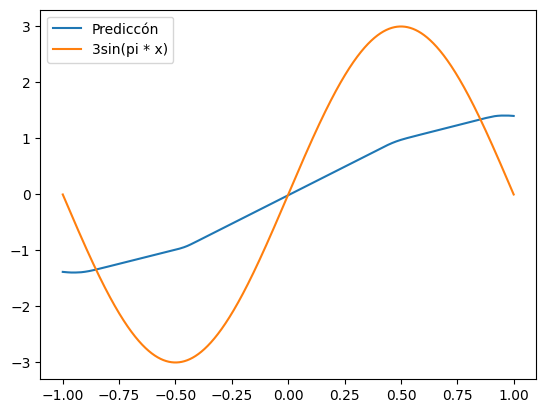

In [146]:
a = model_sin.predict(domain)
plt.plot(domain, a, label = "Prediccón")
plt.plot(domain, codomain_sin, label = "3sin(pi * x)")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

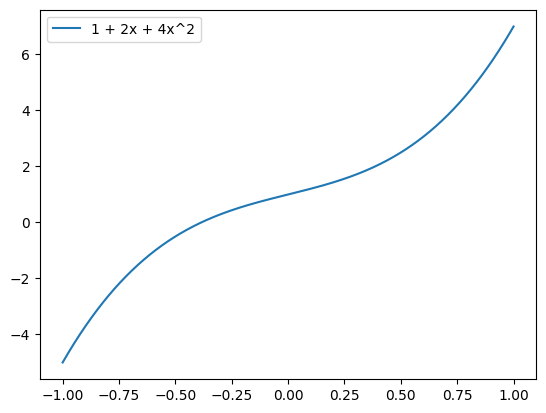

In [147]:
plt.plot(domain, codomain_pol, label = "1 + 2x + 4x^2")
plt.legend()
plt.show